In [0]:
# Check GPU enable on Colab
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0    996      0 --:--:-- --:--:-- --:--:--   996
Updating fastai...
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


In [0]:
# Import libs
from fastai.vision import *

# Setup 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Multi-label prediction with Planet Amazon dataset

In [0]:
# Install Kaggle library
!pip3 install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.3)


In [0]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir -p ~/.kaggle/
!mv kaggle.json ~/.kaggle/

In [0]:
path = Config.data_path()/"planet"
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [0]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}
!unzip -q -n {path}/train_v2.csv.zip -d {path}

 99% 593M/600M [00:12<00:00, 48.7MB/s]
100% 600M/600M [00:12<00:00, 50.8MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 61.5MB/s]


In [0]:
!7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

## Muticlassification

In [0]:
df = pd.read_csv(path/"train_v2.csv")
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Using the [data block API](https://docs.fast.ai/data_block.html)'s ImageList that puts train data to DataBunch.

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, "train_v2.csv", folder="train-jpg", suffix=".jpg")
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=" "))

In [0]:
data = (src.transform(tfms, size=256).databunch().normalize(imagenet_stats))

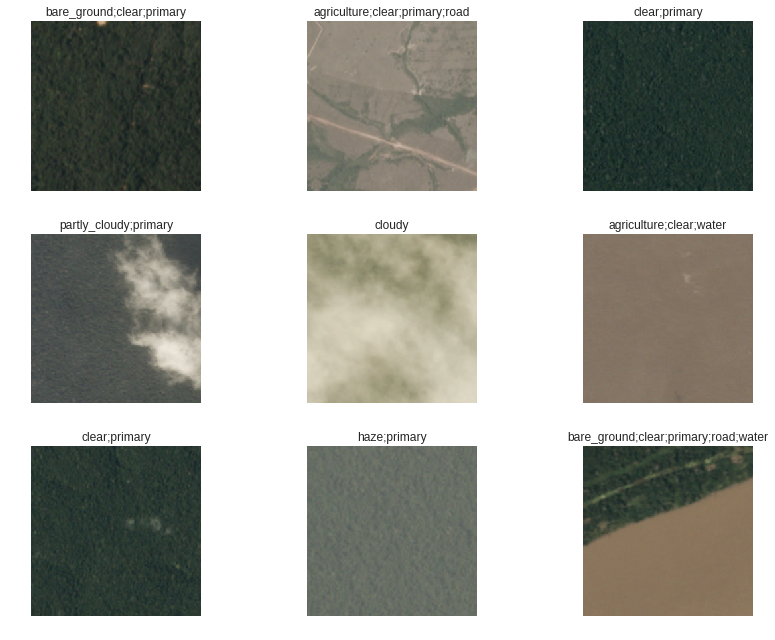

In [0]:
data.show_batch(rows=3, figsize=(12, 9))

In [0]:
arch = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)

In [0]:
f_score = partial(fbeta, thresh=0.2)

In [0]:
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 88903006.37it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


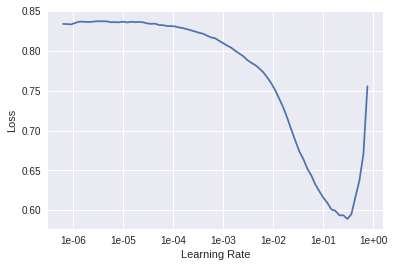

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 0.01

In [0]:
learn.fit_one_cycle(5, max_lr=slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.119754,0.106301,0.948872,0.904105,11:20
1,0.107395,0.096682,0.958914,0.916066,11:14
2,0.101277,0.088992,0.958878,0.924500,11:14
3,0.092689,0.084848,0.957199,0.928003,11:13
4,0.087636,0.084069,0.958064,0.928114,11:17


In [0]:
learn.save("stage-1")

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


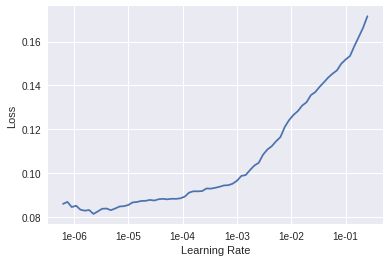

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.095594,0.088867,0.952817,0.925054,14:46
1,0.093706,0.091134,0.958348,0.922202,14:48
2,0.090653,0.084190,0.957207,0.928103,14:52
3,0.083884,0.081912,0.960833,0.930539,14:50
4,0.078614,0.080524,0.958537,0.931086,14:51


In [0]:
learn.save("stage-2")

In [0]:
learn.export()

In [0]:
data = (src.transform(tfms, size=256)
        .databunch(num_workers=0).normalize(imagenet_stats))
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


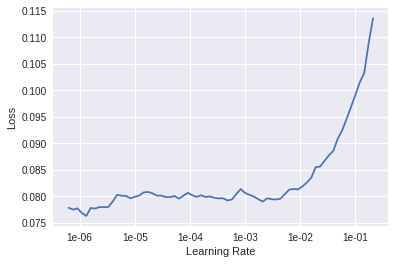

In [0]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2/2

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.081955,0.082338,0.956945,0.928249,17:46
1,0.081775,0.085927,0.958798,0.928961,17:47
2,0.083993,0.084492,0.959735,0.929158,17:47
3,0.078633,0.081216,0.959394,0.930102,17:47
4,0.075603,0.081737,0.959670,0.930286,17:54


In [0]:
learn.save("stage-1-256")

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.079904,0.083470,0.959263,0.929503,21:29
1,0.085689,0.083669,0.958471,0.928333,21:29
2,0.080676,0.085340,0.956567,0.928626,21:26
3,0.076275,0.086744,0.958522,0.929395,21:21
4,0.072284,0.083421,0.959198,0.930305,21:21


In [0]:
learn.save('stage-2-256')

In [0]:
learn.export()

In [0]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}
!7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}

100% 601M/603M [00:14<00:00, 31.7MB/s]
100% 603M/603M [00:14<00:00, 42.5MB/s]


In [0]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}
!7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

 96% 291M/304M [00:06<00:00, 43.7MB/s]
100% 304M/304M [00:06<00:00, 48.8MB/s]


In [0]:
test = ImageList.from_folder(path/"test-jpg").add(ImageList.from_folder(path/"test-jpg-additional"))
len(test)

61191

In [0]:
learn_test = load_learner(path, test=test)
preds, _ = learn_test.get_preds(ds_type=DatasetType.Test)

In [0]:
print(preds[:10])

tensor([[8.1786e-04, 8.0124e-07, 5.9571e-05, 5.6783e-04, 1.7226e-05, 9.9965e-01,
         1.9996e-05, 4.5841e-07, 2.4531e-04, 1.0573e-03, 1.2208e-04, 5.8075e-05,
         9.9989e-01, 2.7805e-04, 5.6949e-05, 8.1001e-07, 1.7359e-03],
        [7.1170e-01, 5.6113e-05, 2.1335e-02, 2.6965e-03, 2.7120e-03, 1.4662e-02,
         3.0803e-04, 5.2888e-05, 7.1519e-01, 1.9033e-03, 1.9114e-03, 9.7778e-01,
         9.9961e-01, 1.6312e-02, 4.3195e-03, 1.8080e-02, 2.7988e-02],
        [2.2621e-03, 8.1271e-08, 7.2287e-05, 1.4753e-03, 5.8959e-05, 9.9979e-01,
         1.8233e-05, 4.9868e-07, 3.1282e-04, 1.9888e-03, 1.4719e-04, 2.7077e-05,
         9.9991e-01, 1.8084e-03, 2.6092e-04, 2.9479e-06, 2.0770e-03],
        [1.1094e-02, 5.4391e-07, 1.4542e-04, 6.3837e-04, 1.9805e-03, 9.9962e-01,
         1.2251e-05, 1.0353e-07, 8.0277e-03, 7.2383e-05, 6.5421e-05, 2.0180e-04,
         9.9998e-01, 8.0811e-05, 8.8190e-05, 3.5238e-05, 3.7910e-04],
        [8.5091e-01, 7.8675e-05, 2.4259e-01, 4.1353e-05, 2.2243e-05, 9.9

In [0]:
thresh = 0.2
labelled_preds = [" ".join([learn_test.data.classes[i] for i, p in enumerate(pred) if p > thresh]) for pred in preds]
file_names = [f.name[:-4] for f in learn_test.data.test_ds.items]
df = pd.DataFrame({"image_name": file_names, "tags": labelled_preds}, columns=["image_name", "tags"])
df.to_csv(path/"submission_02.csv", index=False)

In [0]:
thresh = 0.18
labelled_preds = [" ".join([learn_test.data.classes[i] for i, p in enumerate(pred) if p > thresh]) for pred in preds]
file_names = [f.name[:-4] for f in learn_test.data.test_ds.items]
df = pd.DataFrame({"image_name": file_names, "tags": labelled_preds}, columns=["image_name", "tags"])
df.to_csv(path/"submission_018.csv", index=False)

In [0]:
!kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/"submission_02.csv"} -m "submission_02"

100% 2.20M/2.20M [00:10<00:00, 224kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

* Thread = 0.2,   Score = 0.93009
* Thread = 0.18, Score = 0.93032